### CUNY Data 620 - Web Analytics, Summer 2020
**Group Project 1**  
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout  

### Instructions
1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as spy
import numpy as np
import statistics

In [2]:
composerFile = "data/composers.txt"

composers = []
composerfile = open(composerFile, 'r') 
for line in composerfile.readlines(): 
    for element in line[0:-1].split('\t'):
        composers.append(element)
composers = [item for item in composers if composers not in ['\n', '']]
composers = [string for string in composers if string != ""]

In [3]:
producerFile = "data/producers.txt"

producers = []
producerfile = open(producerFile, 'r') 
for line in producerfile.readlines(): 
    for element in line[0:-1].split('\t'):
        producers.append(element)
producers = [item for item in producers if producers not in ['\n', ',']]
producers = [string for string in producers if string != ""]

In [4]:
interaction_matrix = "data/matrix.txt"

interaction_mat = []
interactfile = open(interaction_matrix, 'r') 
for line in interactfile.readlines(): 
    for element in line[0:-1].split('\n'):
        interaction_mat.append(element)
interaction_mat = [item for item in interaction_mat if interaction_mat not in ['\n', '']]
interaction_mat = [string for string in interaction_mat if string != ""]

In [5]:
producers = "\n".join(producers)
composers = "\n".join(composers)
interaction_mat = "\n".join(interaction_mat)

In [6]:
print(interaction_mat)

3	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	2	2	0	1	0	0	0	0	0
1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	2	0	0	0	0
1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0
1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	1
1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	4	0	0	0	2	0	0	0	0	0	0	0
1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
1	0	1	0	3	2	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
4	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
2	3	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

In [7]:
def hollywood_graph(create_using=None, **kwds):
    composers_num=40
    producers_num=62
    g=nx.generators.empty_graph(composers_num+producers_num,create_using=create_using,**kwds)
    g.clear()
    g.name="Hollywood Film Music"
    
    # loading the women's names
    producers_list=producers

    # loading the club names
    composers_list=composers

    # loading the interaction matrix
    interaction_matrix=interaction_mat
    
    # creating a list of women names
    c={}
    n=0
    for name in composers_list.split('\n'):
        c[n]=name
        n+=1

    # creating a list of club names
    p={}
    n=0
    for name in producers_list.split('\n'):
        p[n]=name
        n+=1
        
    print(p)
    print(c)

    # parsing our interactions matrix, adding edges
    row=0
    for line in interaction_matrix.split('\n'):
        thisrow=list(map(int,line.split('\t')))
        for col in range(0,len(thisrow)):
            if thisrow[col]==1:
                g.add_edge(p[row],c[col])
        row+=1
    print(g)
    return (g)

In [8]:
(g)=hollywood_graph()

{0: 'Rosenberg, A.', 1: 'Chartoff-Winkler', 2: 'Wise, R.', 3: 'Schwartz, M.', 4: 'Arthur, R.', 5: 'Dehaven, C.', 6: 'Fryer-Cresson', 7: 'Montagne, E.', 8: 'Edwards, B.', 9: 'Lewis, E.', 10: 'Hibler, W.', 11: 'David, S.', 12: 'Jacobs, A.', 13: 'Preminger, O.', 14: 'Seltzer, W.', 15: 'Conrad, W.', 16: 'Dorfman, R.', 17: 'Towers, I.', 18: 'Anderson, B.', 19: 'Miller, R.', 20: 'Walsh, B.', 21: 'Turman-Foster', 22: 'Radnitz, R.', 23: 'Lyles, A.C.', 24: 'Aldrich, R.', 25: 'Arkoff, S.', 26: 'Katzman, S.', 27: 'Pressman, E.', 28: 'Corman, R.', 29: 'Wallis, H.', 30: 'Jewison, N.', 31: 'Allen, I.', 32: 'Mirisch, W.', 33: 'Weintraub-Heller', 34: 'Frankovich, M.', 35: 'Kastner, E.', 36: 'Delaurentis, D.', 37: 'Lang, J.', 38: 'Relyea, R.', 39: 'Levy-Gardner', 40: 'Daley, R.', 41: 'Ransohoff, M.', 42: 'Howard, S.', 43: 'Wolper, D.', 44: 'Lawrence, D.', 45: 'Beckerman, S.', 46: 'Castle, W. ', 47: 'Hunter, R.', 48: 'Ruddy, A.', 49: 'Zanuck-Brown', 50: 'Pakula, A.', 51: 'Foreman, J.', 52: 'Koch, H.', 5

In [9]:
print(nx.info(g))

Name: Hollywood Film Music
Type: Graph
Number of nodes: 93
Number of edges: 135
Average degree:   2.9032


In [10]:
g.nodes

NodeView(('Rosenberg, A.', 'Devol, F.', 'Bernstein, E.', 'Chartoff-Winkler', 'Grusin, D.', 'Karlin, F.', 'Wise, R.', 'Goldsmith, J.', 'Schwartz, M.', 'Schifrin, L.', 'North, A.', 'Arthur, R.', 'Rosenman, L.', 'Mizzy, V.', 'Dehaven, C.', 'Fielding, J.', 'Phillips, S', 'Fryer-Cresson', 'Montagne, E.', 'Hefti, N.', 'Edwards, B.', 'Lewis, E.', 'Hibler, W.', 'Sherman, R/R', 'Jarre, M.', 'David, S.', 'Preminger, O.', 'Myrow, F.', 'Seltzer, W.', 'Frontiere, D.', 'Dorfman, R.', 'Towers, I.', 'Bruns, G.', 'Anderson, B.', 'Walsh, B.', 'Baker, B.', 'Turman-Foster', 'Mandel, J.', 'Small, M.', 'Radnitz, R.', 'Arkoff, S.', 'Bernstein, C.', 'Pressman, E.', 'Corman, R.', 'Baxter, L.', 'Fried, J.', 'Wallis, H.', 'Jewison, N.', 'Mancini, H.', 'Williams, J.', 'Legrand, M.', 'Allen, I.', 'Mirisch, W.', 'Jones, Q.', 'Frankovich, M.', 'Kastner, E.', 'Shire, D.', 'Delaurentis, D.', 'Barry, J.', 'Lang, J.', 'Relyea, R.', 'Levy-Gardner', 'Haskell, J.', 'Daley, R.', 'Ransohoff, M.', 'Karger, F.', 'Hamlisch, M.'

In [11]:
nx.is_bipartite(g)

True

In [12]:
g.edges

EdgeView([('Rosenberg, A.', 'Devol, F.'), ('Rosenberg, A.', 'Bernstein, E.'), ('Devol, F.', 'Kramer, S.'), ('Bernstein, E.', 'Lewis, E.'), ('Bernstein, E.', 'Allen, I.'), ('Bernstein, E.', 'Mirisch, W.'), ('Bernstein, E.', 'Delaurentis, D.'), ('Bernstein, E.', 'Relyea, R.'), ('Bernstein, E.', 'Wolper, D.'), ('Bernstein, E.', 'Hunter, R.'), ('Bernstein, E.', 'Pakula, A.'), ('Chartoff-Winkler', 'Grusin, D.'), ('Chartoff-Winkler', 'Karlin, F.'), ('Grusin, D.', 'Turman-Foster'), ('Grusin, D.', 'Wallis, H.'), ('Grusin, D.', 'Lang, J.'), ('Grusin, D.', 'Foreman, J.'), ('Grusin, D.', 'Joffe, C.'), ('Karlin, F.', 'Wise, R.'), ('Karlin, F.', 'Turman-Foster'), ('Karlin, F.', 'Radnitz, R.'), ('Karlin, F.', 'Mirisch, W.'), ('Wise, R.', 'Goldsmith, J.'), ('Goldsmith, J.', 'Schwartz, M.'), ('Goldsmith, J.', 'Arthur, R.'), ('Goldsmith, J.', 'Dehaven, C.'), ('Goldsmith, J.', 'Fryer-Cresson'), ('Goldsmith, J.', 'Montagne, E.'), ('Goldsmith, J.', 'Edwards, B.'), ('Goldsmith, J.', 'Hibler, W.'), ('Goldsm

In [13]:
print(g.edges[('Rosenberg, A.', 'Devol, F.')])

{}


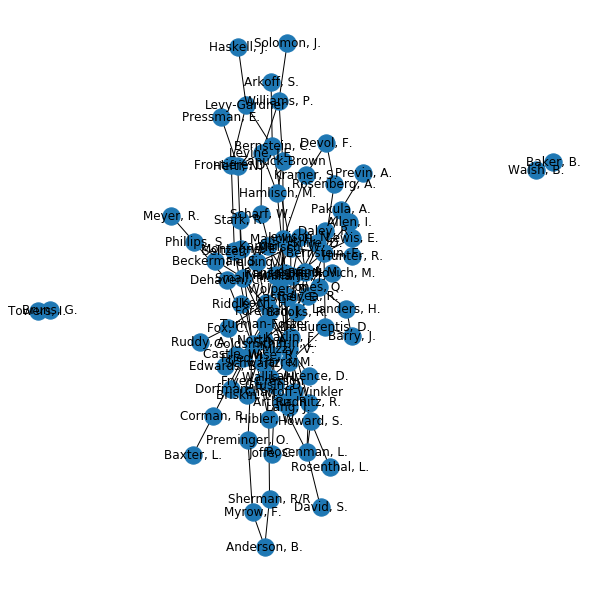

In [14]:
plt.rcParams['figure.figsize'] = [8, 8]
nx.draw_spring(g, with_labels='true')